# GEOPHYSICAL SIGNAL IN-PAINTING:






__Joshua Dickey, PhD, PE__

_Senior Technical Advisor for Machine Intelligence_

_Air Force Technical Applications Center / Systems Development_


_______________________

In [1]:
import numpy as np
import pandas as pd

import obspy


import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display
from time import localtime, strftime

%matplotlib inline
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from tensorflow.python.ops import math_ops
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, Flatten, Activation, Lambda, Convolution1D, Dense, BatchNormalization, add
from tensorflow.keras.models import Model, load_model, Sequential, save_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from numpy.fft import fft, ifft
from tensorflow.keras.utils import to_categorical
from scipy.special import softmax
from scipy.signal import lfilter, butter, decimate

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from math import radians, degrees, cos, sin


model_folder = 'models/'
log_folder = 'logs/'

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[3], 'GPU')

# Introduction:

This notebook explores a deep neural network methodology for replacing geophysical signal gaps with smooth natural signal.

## Background:
Geophysical sensor data is fundamental for AFTAC’s nuclear treaty monitoring mission. Our global sensor grid provides near-real time waveforms from air land and sea with over 98% data availability. However, this data can sometimes suffer corruption for short periods of time, due to digital artifacts, communications interruptions, sensor self-noise, or even natural molestation of the sensor. These short period data gaps are problematic for AFTAC’s processing algorithms, as the corrupted waveforms can include discontinuities which wreak havoc on downstream filtering. 

<img src="gap.jpg">



## Task Formulation:
The project will borrow from recent state-of-the-art research in image and audio in-painting, and the algorithm will be formulated as a sequence-to-sequence model, where an uncorrupted gapless sequence is supplied as a label and a corrupted, gap-filled version of the same sequence is supplied as an input. 

The model will be optimized based on a joint loss function with two parts. 
1) The first loss function focuses on signal reconstruction, using mean squared error loss to regress on the original signal data that was removed. 

2) The second loss function focuses on signal continuity, seeking to preserve the natural smoothness of the sample space through implementation of a generative adversarial network (GAN). 


# Data Exploration:

Data for training this model is both readily available and virtually unlimited… any healthy segment of seismic, hydro-acoustic or infrasound data can be utilized. In this notebook, we utilize obspy to download a small numpy array of seismic data. We then define a generator function to randomly sample from this data and build input/output pairs for training and validation.

In [2]:
x = np.load('data_small.npy').astype('float32')

In [3]:
# Model Parameters
pdict = {}
pdict['f']     = 10
pdict['k']     = 15
pdict['d']     = [2, 4, 8, 16]
pdict['s']     = 1

# Dataset Parameters
pdict['flo']   = .3
pdict['fhi']   = 5
pdict['wlen']  = 20
pdict['glen']  = 1
pdict['gskp']  = 30
pdict['fs']    = 40


# Training Parameters
pdict['bs']    = 32
pdict['lr']    = .0005
pdict['pat']   = 2
pdict['time']  = strftime("%y-%m-%d-%H-%M-%S", localtime())


In [4]:
def gen(x, pdict, rand=1):
    # calculate the gap length and window length in samples
    g_len = int(pdict['glen'] * pdict['fs'])
    w_len = int(pdict['wlen'] * pdict['fs'])
    idx = int(w_len/2)

    while 1:
        sample_index_batch = np.random.randint(x.shape[0], size=pdict['bs'])
        sample_index_time = np.random.randint(x.shape[1] - w_len)
        
        my_y = np.expand_dims(x[sample_index_batch,sample_index_time:sample_index_time+w_len], 2)
        mask = np.ones(my_y.shape)
        
        my_y = np.concatenate([my_y, mask], 2)
        my_x = np.copy(my_y)
        
        my_x[:, idx:idx+g_len, :] = 0
        my_y[:, idx:idx+g_len, 1] = 0

        yield my_x, my_y

In [14]:
trn_gen = gen(x[:600], pdict)
val_gen = gen(x[600:], pdict)

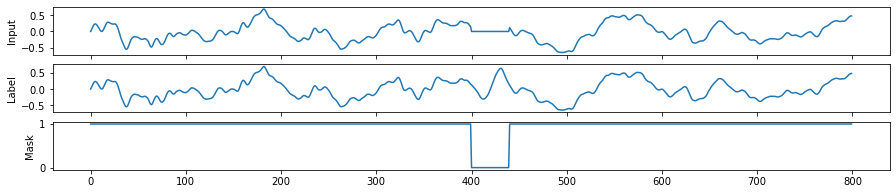

In [15]:
X, Y = next(trn_gen)
            
fig, ax = plt.subplots(3,1, figsize=(15,3), sharex=True)

ax[0].plot(X[0,:,0])
ax[1].plot(Y[0,:,0])
ax[2].plot(Y[0,:,1])

ax[0].set_ylabel('Input')
ax[1].set_ylabel('Label')
ax[2].set_ylabel('Mask')

fig.savefig('gap.jpg')

# Temporal Convolutional Neural Network Architecture:

In this work, we utilize the TCN architecture to perform sequence to sequence modeling. This means that both the input and output of the model are time series sequences of equal length. 

In [16]:
def residual_block(x, dilation_rate, nb_filters, kernel_size, padding, dropout_rate=0):

    prev_x = x
    for k in range(2):
        x = Conv1D(filters=nb_filters,
                   kernel_size=kernel_size,
                   dilation_rate=dilation_rate,
                   padding=padding)(x)
        x = Activation('relu')(x)
        x = SpatialDropout1D(rate=dropout_rate)(x)

    # 1x1 conv to match the shapes (channel dimension).
    prev_x = Conv1D(nb_filters, 1, padding='same')(prev_x)
    res_x = add([prev_x, x])
    return res_x, x


def base_model(win_len, nb_chan, nb_filters, filter_len, dilations, nb_stacks,
               padding='same', drop=0.05):

    input_layer = Input(shape=(win_len, nb_chan))
    orig_data, mask = tf.split(input_layer, 2, 2)
    
    x = input_layer
    x = Convolution1D(nb_filters, 1, padding=padding)(x)
    skip_connections = []
    for s in range(nb_stacks):
        for d in dilations:
            x, skip_out = residual_block(x,
                                         dilation_rate=d,
                                         nb_filters=nb_filters,
                                         kernel_size=filter_len,
                                         padding=padding,
                                         dropout_rate=drop)
            skip_connections.append(skip_out)

    x = add(skip_connections)
    
    x = Dense(1)(x)
    
    predict = orig_data + x * (1.-mask)
    output_layer = tf.concat([predict, mask], 2)
    model = Model(input_layer, output_layer)

    return model

In [17]:
def param2name(pdict):
    name = []
    for key in pdict.keys():
        if type(pdict[key]) is list:
            name.append(f'{key}:{"x".join(map(str, pdict[key]))}')
        else:
            name.append(f'{key}:{pdict[key]}')
    return '|'.join(name)
           
                        
def name2param(name):
    name = name[:-3]
    regnumber = re.compile(r'^\d+(\.\d+)?$')
    pdict = dict([p.split(':') for p in name.split('|')])
    for key in pdict.keys():
        if regnumber.match(pdict[key]):
            try:
                pdict[key] = int(pdict[key])
            except:
                pdict[key] = float(pdict[key])
        else:
            if 'x' in pdict[key]:
                pdict[key] = list(map(int, pdict[key].split('x')))
            try:
                pdict[key] = float(pdict[key])
            except:
                pass
    return pdict

In [18]:
def get_loss(alpha=1):
    def mse_loss(y_true, y_pred):
        y_true, mask = tf.split(y_true, 2, 2)
        y_pred, mask = tf.split(y_pred, 2, 2)
        return K.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
    
    def trimmed_loss(y_true, y_pred):
        y_true, mask = tf.split(y_true, 2, 2)
        y_pred, mask = tf.split(y_pred, 2, 2)
        diff = math_ops.squared_difference(y_pred, y_true)
        diff = tf.boolean_mask(diff, 1-mask[0,:,0], axis=1)
        return K.mean(diff, axis=1)
    
    def weighted_loss(y_true, y_pred):
        y_true, mask = tf.split(y_true, 2, 2)
        y_pred, mask = tf.split(y_pred, 2, 2)
        diff = math_ops.squared_difference(y_pred, y_true)
        w = tf.nn.convolution(mask[:1], tf.ones((50, 1, 1)), padding='SAME')
        w = w / K.max(w) * 2 + 1
        diff = diff * w
        diff = tf.boolean_mask(diff, 1-mask[0,:,0], axis=1)
        return K.mean(diff, axis=1)

    return weighted_loss


def load_custom_model(pdict, model_folder='models'):
    if 'iniW' in pdict.keys():
        model_name = [n for n in os.listdir(model_folder) if f"|time:{pdict['iniW']}" in n][0]
        model_file = os.path.join(model_folder, model_name)

        print('loading previous model:\n', model_file)
        pdict = name2param(os.path.basename(model_file))
        my_loss = get_loss()
        model = load_model(model_file, custom_objects={'mse_loss': my_loss})
    else:
        model_name = param2name(pdict)
        model_file = os.path.join(model_folder, model_name)
        
        print('building new model:\n', model_file)
        model = base_model(win_len=None,
                           nb_chan=2,
                           nb_filters=pdict['f'],
                           filter_len=pdict['k'],
                           dilations=pdict['d'],
                           nb_stacks=pdict['s'])
    return model, model_name


def compile_custom_model(model, pdict):
    o = Adam(lr=pdict['lr'], clipnorm=1.)
    my_loss = get_loss()                  
    model.compile(loss=my_loss, optimizer=o, metrics=['mae'])

    return model, param2name(pdict)


def get_callbacks(model_name, model_folder, log_folder):
    pdict = name2param(os.path.basename(model_name))
    tensor_foldername = os.path.join(log_folder, model_name)
    model_filename = os.path.join(model_folder, model_name + '.h5')

    sv = ModelCheckpoint(filepath=model_filename, monitor='val_loss', save_best_only=True,
                                         save_weights_only=False, mode='min')
    tbd = TensorBoard(log_dir=tensor_foldername)
    stp = EarlyStopping(monitor='val_loss', min_delta=0, patience=pdict['pat'],
                                        verbose=0, mode='min', baseline=None)

    return [sv, tbd, stp]



In [19]:
t_step = 100
v_step = 100

In [20]:
# Build the Model
print('loading model...', end=' ', flush=True)
model, model_name = load_custom_model(pdict)

pdict = name2param(model_name)


model, _ = compile_custom_model(model, pdict)
print('complete')
print(model.summary())

model, model_name = compile_custom_model(model, pdict)
print(model_name)
model_id = pdict['time']

loading model... building new model:
 models/f:10|k:15|d:2x4x8x16|s:1|flo:0.3|fhi:5|wlen:20|glen:1|gskp:30|fs:40|bs:32|lr:0.0005|pat:2|time:21-04-02-20-39
complete
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, None, 10)     30          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, None, 10)     1510        conv1d_13[0][0]                  
__________________________________________________________________________________________________
activation_8 (Activation)  

In [21]:
history = model.fit_generator(trn_gen, steps_per_epoch=t_step, epochs=5000,
                              validation_data=val_gen, validation_steps=v_step,
                              callbacks=get_callbacks(model_name, model_folder, log_folder),
                              max_queue_size=10)

Epoch 1/5000
100/100 [==============================] - 2s 20ms/step - loss: 0.1000 - mae: 0.0043 - val_loss: 0.0460 - val_mae: 0.0031
Epoch 2/5000
100/100 [==============================] - 1s 11ms/step - loss: 0.0433 - mae: 0.0030 - val_loss: 0.0437 - val_mae: 0.0030
Epoch 3/5000
100/100 [==============================] - 1s 11ms/step - loss: 0.0471 - mae: 0.0031 - val_loss: 0.0392 - val_mae: 0.0028
Epoch 4/5000
100/100 [==============================] - 1s 11ms/step - loss: 0.0410 - mae: 0.0029 - val_loss: 0.0397 - val_mae: 0.0028
Epoch 5/5000
100/100 [==============================] - 1s 11ms/step - loss: 0.0400 - mae: 0.0028 - val_loss: 0.0334 - val_mae: 0.0025
Epoch 6/5000
100/100 [==============================] - 1s 11ms/step - loss: 0.0401 - mae: 0.0028 - val_loss: 0.0342 - val_mae: 0.0026
Epoch 7/5000
100/100 [==============================] - 1s 11ms/step - loss: 0.0344 - mae: 0.0026 - val_loss: 0.0331 - val_mae: 0.0025
Epoch 8/5000
100/100 [==============================] -

In [25]:
val_gen = gen(x[600:], pdict, rand=0)
X, Y = next(val_gen)
Z = model.predict(X)

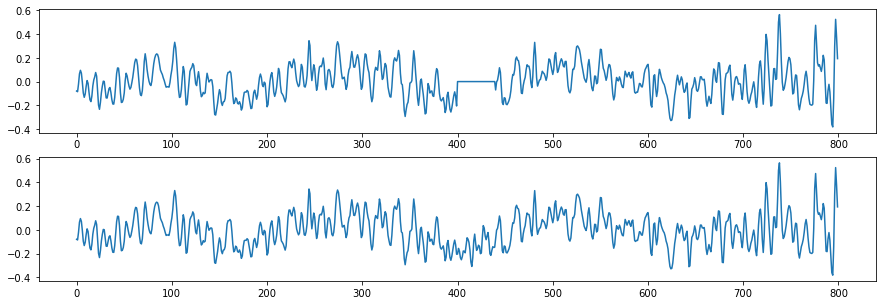

In [26]:
fig, ax = plt.subplots(2,1,figsize=(15,5))

ax[0].plot(X[0,:,0])
ax[1].plot(Y[0,:,0])


plt.savefig('seismogap.jpg')

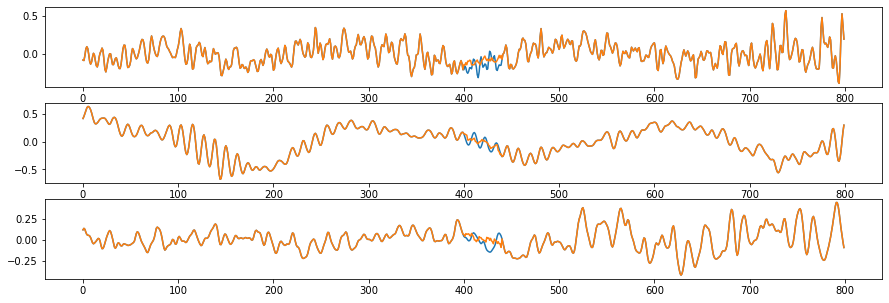

In [27]:
fig, ax = plt.subplots(3,1,figsize=(15,5))

for i in range(3):
    ax[i].plot(Y[i,:,0])
    ax[i].plot(Z[i,:,0])


plt.savefig('seismogap.jpg')